In [1]:
import pysmile
import pysmile_license
import numpy as np

In [2]:
net = pysmile.Network()
net.read_file("genie_models/Basic_ID_screening_06032024.xdsl")

In [3]:
net.set_evidence("CRC", False)
p_CRC_false = net.prob_evidence()

net.set_evidence("CRC", True)
p_CRC_true = net.prob_evidence()

## Using information-related metrics as value functions for a medical test:
Let $X, T, Y$ be random variables describing the results of screening, the results of the colonoscopy and the presence of CRC, respectively; and Z and C decision variables representing the first decision of screening and the decision of colonoscopy. A value function that we could use would be $$V(X,T,Y | Z=z, C=c) = I(X,Y | Z = z) + I(T,Y | C = c)$$ which measures the mutual information of $X$ and $Y$ and the correspondent to $T$ and $Y$. This quantity represents the amount of uncertainty of $Y$ that could be explained by the other variable. 

Check if adding this quantities is correct or if I have to reformulate the value function. 

### Conditional Mutual Information 

##### Screening:

$$ \begin{align*} I(X,Y|Z=z) &= H(X|Z=z) - H(X|Y, Z=z) = \\ 
& = -\sum_{x} p(x|z) \log{p(x|z)} + \sum_{y} p(y|z) \sum_{x} p(x|y,z) \log{p(x|y,z)} = \\
& = \left( \sum_x \sum_y \left( p(y|z) p(x| y,z) \log{ \frac{p(x |y,z)}{\sum_y p(y|z) p(x| y,z)}} \right) \right) = \\
& = \sum_x \sum_y \left( p(y) p(x| y,z) \log{ \frac{p(x |y,z)}{\sum_y p(y) p(x| y,z)}} \right) 
\end{align*}$$

In [4]:
p_y = np.array([p_CRC_false, p_CRC_true])
H_y = np.sum(p_y * np.log(1 / p_y) )
H_y

0.005921053223493746

In [5]:
p_x_yz = np.array(net.get_node_definition("Results_of_Screening")).reshape(2,7,3)

p_y = np.array([p_CRC_false, p_CRC_true])
p_y = np.repeat(p_y, 21).reshape(2,7,3)

p_x_z = p_y * p_x_yz
p_x_z = np.sum(p_x_z, axis = 0)
p_x_z = np.tile(p_x_z, (2,1)).reshape((2,7,3))

p_x_yz.reshape((2,7,3))

first_term = (p_y * ( p_x_yz * np.log( p_x_yz.reshape((2,7,3)) / p_x_z ) ).reshape(2,7,3))
first_term = np.nan_to_num(first_term, 0)
first_term

C:\Users\danie\AppData\Local\Temp\ipykernel_9716\690149611.py:12: RuntimeWarning: invalid value encountered in divide
  first_term = (p_y * ( p_x_yz * np.log( p_x_yz.reshape((2,7,3)) / p_x_z ) ).reshape(2,7,3))


array([[[ 3.62561869e-10,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  3.07467427e-04, -3.05289119e-04],
        [ 0.00000000e+00,  5.14417294e-04, -5.10426459e-04],
        [ 0.00000000e+00,  4.09505292e-04, -4.08483670e-04],
        [ 0.00000000e+00,  5.66899424e-04, -5.65517554e-04],
        [ 0.00000000e+00,  4.95743396e-04, -4.94490962e-04],
        [ 0.00000000e+00,  5.67607253e-04, -5.65427369e-04]],

       [[ 2.60791366e-13,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -2.27425072e-04,  9.71756092e-04],
        [ 0.00000000e+00, -2.42800072e-04,  1.65968602e-03],
        [ 0.00000000e+00, -2.40488489e-04,  9.43049947e-04],
        [ 0.00000000e+00, -1.33906478e-04,  1.27749421e-03],
        [ 0.00000000e+00, -2.14535183e-04,  1.13834374e-03],
        [ 0.00000000e+00, -1.82793292e-04,  1.48793636e-03]]])

In [6]:
import pandas as pd
pd.DataFrame(first_term.flatten()).transpose().to_csv("value_of_info_csv/voi_first_term.csv")

In [7]:
p_x_yz

array([[[1.   , 0.   , 0.   ],
        [0.   , 0.978, 0.022],
        [0.   , 0.966, 0.034],
        [0.   , 0.91 , 0.09 ],
        [0.   , 0.866, 0.134],
        [0.   , 0.89 , 0.11 ],
        [0.   , 0.92 , 0.08 ]],

       [[1.   , 0.   , 0.   ],
        [0.   , 0.55 , 0.45 ],
        [0.   , 0.25 , 0.75 ],
        [0.   , 0.34 , 0.66 ],
        [0.   , 0.077, 0.923],
        [0.   , 0.2  , 0.8  ],
        [0.   , 0.13 , 0.87 ]]])

Mutual Information between two events, aka, **pointwise mutual information**: $ \log \frac{p(x,y)}{p(x)p(y)} $

**Normalized pointwise mutual information**
 
$$ \frac{ \left(\log \frac{p(x,y)}{p(x)p(y)} \right) }{\log p(x,y)} $$

In [8]:
point_mi_scr = np.log( p_x_yz.reshape((2,7,3)) / p_x_z )
point_mi_scr = np.nan_to_num(point_mi_scr, 0)

pd.DataFrame(point_mi_scr.flatten()).transpose().to_csv("value_of_info_csv/point_mi_scr.csv")

point_mi_scr

C:\Users\danie\AppData\Local\Temp\ipykernel_9716\2753185940.py:1: RuntimeWarning: invalid value encountered in divide
  point_mi_scr = np.log( p_x_yz.reshape((2,7,3)) / p_x_z )


array([[[ 3.62822661e-10,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  3.14610009e-04, -1.38867597e-02],
        [ 0.00000000e+00,  5.32906124e-04, -1.50233415e-02],
        [ 0.00000000e+00,  4.50329505e-04, -4.54197215e-03],
        [ 0.00000000e+00,  6.55089140e-04, -4.22331591e-03],
        [ 0.00000000e+00,  5.57415714e-04, -4.49860591e-03],
        [ 0.00000000e+00,  6.17408190e-04, -7.07292602e-03]],

       [[ 3.62822661e-10,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -5.75276782e-01,  3.00431837e+00],
        [ 0.00000000e+00, -1.35117001e+00,  3.07868934e+00],
        [ 0.00000000e+00, -9.84048652e-01,  1.98788819e+00],
        [ 0.00000000e+00, -2.41942440e+00,  1.92556612e+00],
        [ 0.00000000e+00, -1.49234668e+00,  1.97963276e+00],
        [ 0.00000000e+00, -1.95622181e+00,  2.37939365e+00]]])

In [9]:
norm_point_mi_scr = np.log( p_x_yz.reshape((2,7,3)) / p_x_z ) / - np.log( p_x_yz.reshape((2,7,3)) * p_y)
norm_point_mi_scr =  np.nan_to_num(norm_point_mi_scr, 0)
pd.DataFrame(norm_point_mi_scr.flatten()).transpose().to_csv("value_of_info_csv/norm_point_mi_scr.csv")

norm_point_mi_scr

C:\Users\danie\AppData\Local\Temp\ipykernel_9716\2238932833.py:1: RuntimeWarning: invalid value encountered in divide
  norm_point_mi_scr = np.log( p_x_yz.reshape((2,7,3)) / p_x_z ) / - np.log( p_x_yz.reshape((2,7,3)) * p_y)
C:\Users\danie\AppData\Local\Temp\ipykernel_9716\2238932833.py:1: RuntimeWarning: divide by zero encountered in log
  norm_point_mi_scr = np.log( p_x_yz.reshape((2,7,3)) / p_x_z ) / - np.log( p_x_yz.reshape((2,7,3)) * p_y)


array([[[ 5.04590710e-07,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  1.36997505e-02, -3.63772300e-03],
        [ 0.00000000e+00,  1.50920067e-02, -4.44199763e-03],
        [ 0.00000000e+00,  4.73882793e-03, -1.88568058e-03],
        [ 0.00000000e+00,  4.53068536e-03, -2.10048911e-03],
        [ 0.00000000e+00,  4.75396263e-03, -2.03741767e-03],
        [ 0.00000000e+00,  7.34130083e-03, -2.79955372e-03]],

       [[ 5.01278296e-11,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -7.34166045e-02,  3.73836205e-01],
        [ 0.00000000e+00, -1.56671142e-01,  4.09093858e-01],
        [ 0.00000000e+00, -1.18321178e-01,  2.59737048e-01],
        [ 0.00000000e+00, -2.46832221e-01,  2.63124685e-01],
        [ 0.00000000e+00, -1.68676553e-01,  2.65327472e-01],
        [ 0.00000000e+00, -2.10841352e-01,  3.22532962e-01]]])

##### Colonoscopy:

In [10]:
p_t_yc = np.array(net.get_node_definition("Results_of_Colonoscopy")).reshape(2,2,3)
p_t_yc = np.swapaxes(p_t_yc,0,1)

p_y = np.array([p_CRC_false, p_CRC_true])
p_y = np.repeat(p_y, 6).reshape(2,2,3)

p_t_c = p_y * p_t_yc
p_t_c = np.sum(p_t_c, axis = 0)
p_t_c = np.tile(p_t_c, (2,1)).reshape((2,2,3))

p_t_yc.reshape((2,2,3))

second_term = (p_y * (p_t_yc * np.log( p_t_yc.reshape((2,2,3)) / p_t_c ) ).reshape(2,2,3))
second_term = np.nan_to_num(second_term, 0)
second_term = np.swapaxes(second_term,0,1)
second_term
pd.DataFrame((second_term).flatten()).transpose().to_csv("value_of_info_csv/voi_second_term.csv")

C:\Users\danie\AppData\Local\Temp\ipykernel_9716\163820683.py:13: RuntimeWarning: invalid value encountered in divide
  second_term = (p_y * (p_t_yc * np.log( p_t_yc.reshape((2,2,3)) / p_t_c ) ).reshape(2,2,3))


In [11]:
point_mi_col = np.log( p_t_yc.reshape((2,2,3)) / p_t_c )

point_mi_col = np.nan_to_num(point_mi_col, 0)
pd.DataFrame(point_mi_col.flatten()).transpose().to_csv("value_of_info_csv/point_mi_col.csv")
point_mi_col

C:\Users\danie\AppData\Local\Temp\ipykernel_9716\3588007886.py:1: RuntimeWarning: invalid value encountered in divide
  point_mi_col = np.log( p_t_yc.reshape((2,2,3)) / p_t_c )


array([[[ 3.62822661e-10,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  6.97246698e-04, -6.67267450e-02]],

       [[ 3.62822661e-10,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -3.49581031e+00,  4.50798423e+00]]])

In [12]:
norm_point_mi_col = np.log( p_t_yc.reshape((2,2,3)) / p_t_c ) / - np.log( p_t_yc.reshape((2,2,3))* p_y)
norm_point_mi_col =  np.nan_to_num(norm_point_mi_col, 0)
pd.DataFrame(norm_point_mi_col.flatten()).transpose().to_csv("value_of_info_csv/norm_point_mi_col.csv")

norm_point_mi_col

C:\Users\danie\AppData\Local\Temp\ipykernel_9716\3875202604.py:1: RuntimeWarning: invalid value encountered in divide
  norm_point_mi_col = np.log( p_t_yc.reshape((2,2,3)) / p_t_c ) / - np.log( p_t_yc.reshape((2,2,3))* p_y)
C:\Users\danie\AppData\Local\Temp\ipykernel_9716\3875202604.py:1: RuntimeWarning: divide by zero encountered in log
  norm_point_mi_col = np.log( p_t_yc.reshape((2,2,3)) / p_t_c ) / - np.log( p_t_yc.reshape((2,2,3))* p_y)


array([[[ 5.04590710e-07,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  6.47434431e-02, -1.44872666e-02]],

       [[ 5.01278296e-11,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -3.25357919e-01,  6.20216184e-01]]])

---
#### Normalized conditional mutual information

There exist several ways of normalizing the mutual information, but it can be shown that the tightest

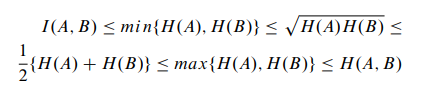

In [13]:
p_y = np.array([p_CRC_false, p_CRC_true])
H_y = np.sum(p_y * np.log(1 / p_y) )
H_y

0.005921053223493746

In [14]:
H_x_z = np.nansum(p_x_z * np.log(1 / p_x_z))
H_x_z

C:\Users\danie\AppData\Local\Temp\ipykernel_9716\3575533937.py:1: RuntimeWarning: divide by zero encountered in divide
  H_x_z = np.nansum(p_x_z * np.log(1 / p_x_z))
C:\Users\danie\AppData\Local\Temp\ipykernel_9716\3575533937.py:1: RuntimeWarning: invalid value encountered in multiply
  H_x_z = np.nansum(p_x_z * np.log(1 / p_x_z))


3.166314560631157

In [15]:
first_term / min(H_y,H_x_z)

array([[[ 6.12326651e-08,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  5.19278269e-02, -5.15599349e-02],
        [ 0.00000000e+00,  8.68793565e-02, -8.62053489e-02],
        [ 0.00000000e+00,  6.91608868e-02, -6.89883463e-02],
        [ 0.00000000e+00,  9.57430042e-02, -9.55096218e-02],
        [ 0.00000000e+00,  8.37255430e-02, -8.35140208e-02],
        [ 0.00000000e+00,  9.58625488e-02, -9.54943905e-02]],

       [[ 4.40447596e-11,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -3.84095639e-02,  1.64118790e-01],
        [ 0.00000000e+00, -4.10062303e-02,  2.80302500e-01],
        [ 0.00000000e+00, -4.06158296e-02,  1.59270642e-01],
        [ 0.00000000e+00, -2.26153140e-02,  2.15754557e-01],
        [ 0.00000000e+00, -3.62326050e-02,  1.92253590e-01],
        [ 0.00000000e+00, -3.08717529e-02,  2.51295893e-01]]])

In [16]:
pd.DataFrame((first_term / min(H_y,H_x_z)).flatten()).transpose().to_csv("value_of_info_csv/voi_first_term_norm.csv")

-----
### Using Mutual Information (without conditioning on screening)

$$ \begin{align*} I(X,Y) &= H(X) - H(X|Y) = \\ 
& = -\sum_{x} p(x) \log{p(x)} + \sum_{y} p(y) \sum_{x} p(x|y) \log{p(x|y)} = \\
& = \left( \sum_x \sum_y \left( p(y|z) p(x| y,z) \log{ \frac{p(x |y,z)}{\sum_y p(y|z) p(x| y,z)}} \right) \right) = \\
& = \sum_x \sum_y \left( \sum_z \frac{1}{|Z|} \left( p(y) p(x| y,z) \log{ \frac{\sum_z p(x |y,z)}{\sum_z \sum_y p(y) p(x| y,z)}} \right) \right) 
\end{align*}$$

In [17]:
p_r_sc = np.array(net.get_node_definition("Results_of_Screening")).reshape(2,7,3)

p_r_c = p_r_sc.mean(axis=1)

p_c = np.array([p_CRC_false, p_CRC_true])
p_c = np.repeat(p_c, 3).reshape(2,3)

p_r = np.repeat((p_c * p_r_c).sum(axis=0) , 2).reshape(3,2).transpose()
p_r

array([[0.14285714, 0.78959101, 0.06755185],
       [0.14285714, 0.78959101, 0.06755185]])

In [18]:
values = (p_c * p_r_c) * np.log(p_r_c / p_r)
values

array([[ 5.17945527e-11,  4.08800617e-04, -4.07454765e-04],
       [ 3.72559094e-14, -2.02273827e-04,  1.02539522e-03]])

#### Normalized M.I.

In [19]:
H_c = - (p_c * np.log(p_c)).sum(axis=0)
H_c

array([0.00592105, 0.00592105, 0.00592105])

In [20]:
norm_values = values / H_c
norm_values

array([[ 8.74752359e-09,  6.90418750e-02, -6.88145757e-02],
       [ 6.29210852e-12, -3.41617984e-02,  1.73177843e-01]])

Colonoscopy

In [21]:
p_t_yc = np.array(net.get_node_definition("Results_of_Colonoscopy")).reshape(2,2,3)
p_t_yc = np.swapaxes(p_t_yc,0,1)

p_t_y = p_t_yc.mean(axis = 1)

p_y = np.array([p_CRC_false, p_CRC_true])
p_y = np.repeat(p_y, 3).reshape(2,3)

p_t = np.repeat((p_y * p_t_y).sum(axis=0) , 2).reshape(3,2).transpose()
p_t

array([[0.5       , 0.49465498, 0.00534502],
       [0.5       , 0.49465498, 0.00534502]])

In [22]:
values = (p_y * p_t_y) * np.log(p_t_y / p_t)
values

array([[ 1.81280935e-10,  3.44889036e-04, -3.33393914e-04],
       [ 1.30395683e-13, -3.76910229e-05,  1.57153093e-03]])

In [23]:
norm_values = values / H_c
norm_values

array([[ 3.06163326e-08,  5.82479203e-02, -5.63065221e-02],
       [ 2.20223798e-11, -6.36559434e-03,  2.65414086e-01]])

#### PMI:

In [24]:
point_mi_scr = np.log( p_x_yz.reshape((2,7,3)).mean(axis=1) / p_x_z.mean(axis=1) )
point_mi_scr = np.nan_to_num(point_mi_scr, 0)

pd.DataFrame(point_mi_scr.flatten()).transpose().to_csv("value_of_info_csv/point_mi_scr.csv")

point_mi_scr

array([[ 3.62822439e-10,  5.17841352e-04, -6.07284029e-03],
       [ 3.62822439e-10, -1.27335240e+00,  2.24252777e+00]])

In [25]:
point_mi_col = np.log( p_t_yc.reshape((2,2,3)).mean(axis=1) / p_t_c.mean(axis=1) )

point_mi_col = np.nan_to_num(point_mi_col, 0)
pd.DataFrame(point_mi_col.flatten()).transpose().to_csv("value_of_info_csv/point_mi_col.csv")

point_mi_col

array([[ 3.62822661e-10,  6.97246698e-04, -6.67267450e-02],
       [ 3.62822661e-10, -3.49581031e+00,  4.50798423e+00]])

##### Norm PMI

In [33]:
point_mi_scr = np.log( p_x_yz.reshape((2,7,3)).mean(axis=1) / p_x_z.mean(axis=1) ) / - np.log( p_x_yz.reshape((2,7,3)).mean(axis=1) *p_y)
point_mi_scr = np.nan_to_num(point_mi_scr, 0)

pd.DataFrame(point_mi_scr.flatten()).transpose().to_csv("value_of_info_csv/norm_point_mi_scr.csv")

point_mi_scr

array([[ 1.86384978e-10,  2.19014691e-03, -2.24782496e-03],
       [ 3.95065346e-11, -1.45566892e-01,  2.91605445e-01]])

In [34]:
point_mi_col = np.log( p_t_yc.reshape((2,2,3)).mean(axis=1) / p_t_c.mean(axis=1) )  /  - np.log( p_t_yc.reshape((2,2,3)).mean(axis = 1) * p_y)

point_mi_col = np.nan_to_num(point_mi_col, 0)
pd.DataFrame(point_mi_col.flatten()).transpose().to_csv("value_of_info_csv/norm_point_mi_col.csv")

point_mi_col

array([[ 5.22900018e-10,  9.90524641e-04, -1.25922413e-02],
       [ 4.57468507e-11, -3.05640507e-01,  5.66219057e-01]])

------------------------
### Kullback Leibler Divergence

In [35]:
p_rc = p_c*(p_r_sc.mean(axis=1)) 
p_c_r = p_rc / p_r

In [36]:
p_c_r

array([[9.99281215e-01, 9.99798818e-01, 9.93231129e-01],
       [7.18784669e-04, 2.01181890e-04, 6.76887106e-03]])

In [37]:
p_c

array([[9.99281215e-01, 9.99281215e-01, 9.99281215e-01],
       [7.18784668e-04, 7.18784668e-04, 7.18784668e-04]])

In [38]:
values_KL = p_c_r * np.log(p_c_r / p_c)
values_KL

array([[ 3.62561869e-10,  5.17737171e-04, -6.03173402e-03],
       [ 2.60791366e-13, -2.56175443e-04,  1.51793813e-02]])

In [39]:
pd.DataFrame(values_KL.flatten()).transpose().to_csv("value_of_info_csv/values_KL_scr.csv")

In [40]:
p_tc = p_c*(p_t_yc.mean(axis=1)) 
p_c_t = p_tc / p_t

In [41]:
p_c_t

array([[9.99281215e-01, 9.99978203e-01, 9.34778395e-01],
       [7.18784669e-04, 2.17965459e-05, 6.52216050e-02]])

In [ ]:
p_c

In [42]:
values_KL = p_c_t * np.log(p_c_t / p_c)
values_KL

array([[ 3.62561869e-10,  6.97231500e-04, -6.23747196e-02],
       [ 2.60791366e-13, -7.61965899e-05,  2.94017967e-01]])

In [43]:
pd.DataFrame(values_KL.flatten()).transpose().to_csv("value_of_info_csv/values_KL_col.csv")

---


### Information gain

In [32]:
net.clear_all_evidence()

net.update_beliefs()

In [33]:
net.set_evidence("CRC", False)
p_CRC_false = net.prob_evidence()

net.set_evidence("CRC", True)
p_CRC_true = net.prob_evidence()

In [34]:
p_r_sc = np.array(net.get_node_definition("Results_of_Screening")).reshape(2,7,3)

p_c = np.array([p_CRC_false, p_CRC_true])
p_c = np.repeat(p_c, 3).reshape(2,3)

In [35]:
sum_p_r_sc = np.array(net.get_node_definition("Results_of_Screening")).reshape(2,7,3).mean(axis = 1)

In [36]:
H_c = - (p_c * np.log(p_c)).sum(axis=0)
H_c

array([0.00592105, 0.00592105, 0.00592105])

In [37]:
p_c = np.array([p_CRC_false, p_CRC_true])
p_c = np.repeat(p_c, 3).reshape(2,3)
p_c

array([[9.99281215e-01, 9.99281215e-01, 9.99281215e-01],
       [7.18784668e-04, 7.18784668e-04, 7.18784668e-04]])

In [38]:
arr = np.repeat((p_c * sum_p_r_sc).sum(axis = 0),2).reshape(3,2).transpose()
arr 

array([[0.14285714, 0.78959101, 0.06755185],
       [0.14285714, 0.78959101, 0.06755185]])

In [39]:
t1 = (p_c * sum_p_r_sc) / arr
t1

array([[9.99281215e-01, 9.99798818e-01, 9.93231129e-01],
       [7.18784669e-04, 2.01181890e-04, 6.76887106e-03]])

In [40]:
H_c_r = -(t1*np.log(t1)).sum(axis = 0)
H_c_r

array([0.00592105, 0.00191348, 0.04055927])

In [41]:
H_c - H_c_r

array([ 3.60674369e-10,  4.00757193e-03, -3.46382175e-02])

### Other alternatives

#### Brier score

In [42]:
df = pd.read_csv("df_2016.csv")

try:
    df.drop(columns = ["Medication", "año_reco", "fpi", "Unnamed: 0"], inplace = True)
except:
    df = df

try:
    df = df[(df["Age"] != "1_very_young") & (df["Age"] != "6_elderly")].copy()
except:
    df = df

try:
    df.rename(columns={"Hyperchol.": "Hyperchol_"}, inplace = True)
except:
    df = df


The following code uses the information for each patient together with the prediction of the screening method (considering randomness in the method, that is, the possibility of making mistakes in the diagnosis) to predict CRC. The motivation is that knowing the screening result could help better diagnosing the patient. However, the task might be difficult due to the class imbalance and thus the probability of a false result being very high. The classification results seem to increase the sensitivity (great) but reduce the specificity (not so great).

Would a slightly different framework aid?? Perhaps performing a colonoscopy after the screening would better the results.

---
Original method: Just use patient data

In [43]:
net.clear_all_evidence()

y_prob_pred = []

for i in range(df.shape[0]):
   
    sample = df.iloc[i].drop(labels = ["CRC"])

    sample_dict = sample.to_dict() 

    for keys, values in sample_dict.items():
        net.set_evidence(keys,values)

    net.update_beliefs()

    crc_probs = net.get_node_value("CRC")

    y_prob_pred.append(crc_probs[1])

KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay, PrecisionRecallDisplay, fbeta_score, brier_score_loss
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean

from sklearn.calibration import calibration_curve, CalibrationDisplay


def evaluate(df_test, test_var, y_prob_pred, weights = [[1],[1]], ):

    g_means_iter = []
    sensitivity_iter = []
    specificity_iter = []
    brier_score = []


    test_var = "CRC"
    # df_test = df

    fpr, tpr, thresholds = roc_curve(list(df_test[test_var]*1), y_prob_pred)
    # calculate the g-mean for each threshold
    gmeans = gmean( [tpr, 1-fpr], axis = 0, weights=weights)
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

    g_means_iter.append(gmeans[ix])


    y_pred = np.where(y_prob_pred > thresholds[ix], 1, 0)

    beta = 2
    fbeta = fbeta_score(list(df_test[test_var]*1), y_pred, beta=beta)
    print(f"F_{beta} score =", fbeta)

    roc_display = RocCurveDisplay.from_predictions(list(df_test[test_var]*1), y_prob_pred)


    conf_mat = confusion_matrix(list(df_test[test_var]), y_pred)
    disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.array(sorted(set(df_test[test_var]*1))) )
    disp.plot()

    brier_score.append(brier_score_loss(list(df_test[test_var]*1), y_prob_pred))

    print("Brier loss:", brier_score_loss(list(df_test[test_var]*1), y_prob_pred))


    prob_true, prob_pred = calibration_curve(list(df_test[test_var]*1), y_prob_pred, n_bins = 10, strategy="quantile")
    disp = CalibrationDisplay(prob_true, prob_pred, y_prob_pred)
    disp.plot(name = test_var)

    plt.xlim([0, max(max(prob_pred), max(prob_true))])  #CRC: 0.005, Diabetes: 0.25
    plt.ylim([0, max(max(prob_pred), max(prob_true))])

    dashed =  len(df_test[df_test[test_var] == True]) / len(df_test)
    plt.axvline(x=dashed, linestyle = '--', color='gray') 

    # Show the modified plot
    plt.title(f"Calibration plot for {test_var}")
    plt.show()

    report = classification_report(list(df_test[test_var]*1), y_pred, output_dict=True)

    print(classification_report(list(df_test[test_var]*1), y_pred))

    sensitivity_iter.append(report["1"]["recall"])
    specificity_iter.append(report["0"]["recall"])

    return y_pred, tpr, fpr, thresholds

Best Threshold=0.000836, G-Mean=0.705
F_2 score = 0.007614500478478746


Brier loss: 0.0006410318746597882


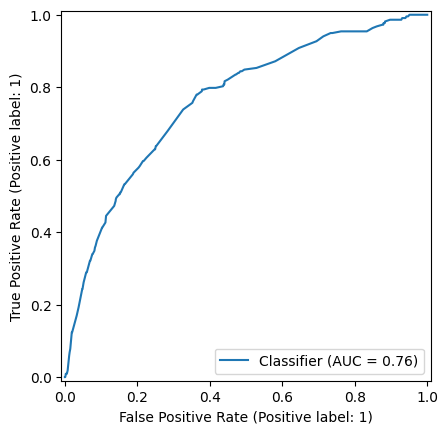

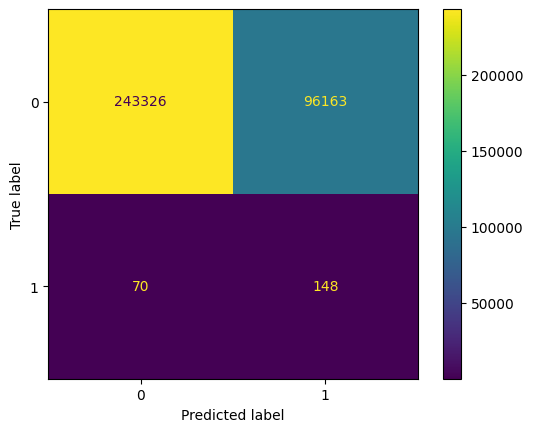

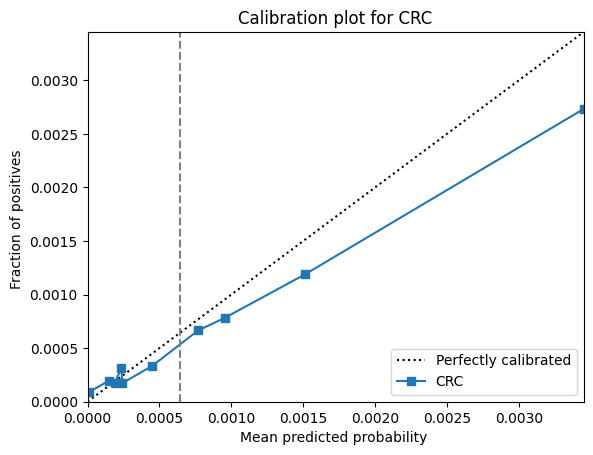

              precision    recall  f1-score   support

           0       1.00      0.72      0.83    339489
           1       0.00      0.68      0.00       218

    accuracy                           0.72    339707
   macro avg       0.50      0.70      0.42    339707
weighted avg       1.00      0.72      0.83    339707



In [ ]:
y_pred, tpr, fpr, thresholds = evaluate(df_test = df, test_var = "CRC", y_prob_pred=y_prob_pred, weights=[[1],[1]])

In [ ]:
def find_thr_sens(df, test_var, y_prob_pred, tpr, fpr, thresholds, minimum_sensitivity):
    g_means_iter = []


    for i in [1,1.5,2,5,10,20,40,80,160]:

        gmeans = gmean( [tpr, 1-fpr], axis = 0, weights=[[i], [1]])
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

        g_means_iter.append(gmeans[ix])


        y_pred = np.where(y_prob_pred > thresholds[ix], 1, 0)

        report = classification_report(list(df[test_var]*1), y_pred, output_dict=True)

        print("Weight =", i)
        print("Sensitivity:", report["1"]["recall"])
        print("Specificity:", report["0"]["recall"])
        print("----------")

        if minimum_sensitivity < report["1"]["recall"]:
            print("Sensitivity:", report["1"]["recall"])
            print("Specificity:", report["0"]["recall"])

            print("Threshold:", thresholds[ix])
            return y_pred, thresholds[ix]
        
    
    return y_pred, thresholds[ix]
    

In [ ]:
y_pred, thr = find_thr_sens(df, "CRC", y_prob_pred, tpr, fpr, thresholds, minimum_sensitivity = 0.9)

Best Threshold=0.000836, G-Mean=0.705


Weight = 1
Sensitivity: 0.6788990825688074
Specificity: 0.7167419268370993
----------
Best Threshold=0.000717, G-Mean=0.720
Weight = 1.5
Sensitivity: 0.7889908256880734
Specificity: 0.6220407730441929
----------
Best Threshold=0.000717, G-Mean=0.732
Weight = 2
Sensitivity: 0.7889908256880734
Specificity: 0.6220407730441929
----------
Best Threshold=0.000253, G-Mean=0.778
Weight = 5
Sensitivity: 0.8440366972477065
Specificity: 0.5118722550657017
----------
Best Threshold=0.000195, G-Mean=0.846
Weight = 10
Sensitivity: 0.9403669724770642
Specificity: 0.28680752542792254
----------
Sensitivity: 0.9403669724770642
Specificity: 0.28680752542792254
Threshold: 0.00019494499999999997


In [ ]:
df[ df["CRC"] == y_pred].head()

,Age,Sex,BMI,Alcohol,Smoking,PA,Depression,Anxiety,Diabetes,Hypertension,Hyperchol_,SD,SES,CRC
14,age_3_young_adult,M,bmi_4_obese,low,sm_2_smoker,PA_1,False,False,False,False,True,SD_2_normal,ses_2,False
18,age_2_young,W,bmi_2_normal,low,sm_1_not_smoker,PA_2,False,True,False,False,False,SD_2_normal,ses_1,False
22,age_4_adult,M,bmi_3_overweight,low,sm_3_ex_smoker,PA_1,False,False,True,False,True,SD_1_short,ses_2,False
30,age_4_adult,W,bmi_3_overweight,low,sm_2_smoker,PA_1,False,False,False,False,True,SD_2_normal,ses_2,False
32,age_5_old_adult,W,bmi_2_normal,low,sm_2_smoker,PA_1,False,False,False,False,True,SD_1_short,ses_1,False


In [ ]:
df_to_screen = df[ df["CRC"] != y_pred ].reset_index(drop = True)
df_to_screen.head()

,Age,Sex,BMI,Alcohol,Smoking,PA,Depression,Anxiety,Diabetes,Hypertension,Hyperchol_,SD,SES,CRC
0,age_3_young_adult,M,bmi_3_overweight,low,sm_1_not_smoker,PA_2,False,False,False,False,False,SD_2_normal,ses_1,False
1,age_4_adult,M,bmi_3_overweight,low,sm_2_smoker,PA_1,False,False,False,False,False,SD_2_normal,ses_1,False
2,age_5_old_adult,M,bmi_4_obese,low,sm_3_ex_smoker,PA_2,False,False,False,True,False,SD_2_normal,ses_1,False
3,age_4_adult,M,bmi_2_normal,low,sm_1_not_smoker,PA_2,False,False,False,False,False,SD_2_normal,ses_1,False
4,age_3_young_adult,M,bmi_3_overweight,low,sm_1_not_smoker,PA_1,False,False,False,False,False,SD_2_normal,ses_1,False


---
Option #1: Do Colonoscopy for FIT positive

In [ ]:
net.clear_all_evidence()
net.set_evidence("Screening", "FIT")

y_prob_pred = []

for i in range(df_to_screen.shape[0]):
    net.clear_evidence("Results_of_Screening")
    net.clear_evidence("Results_of_Colonoscopy")
    net.clear_evidence("Colonoscopy")
   
    sample = df_to_screen.iloc[i].drop(labels = ["CRC"])

    sample_dict = sample.to_dict() 

    for keys, values in sample_dict.items():
        net.set_evidence(keys,values)

    net.update_beliefs()
    
    # Get probabilities of predicting or not CRC, choose one randomly using these probs
    scr_result_probs = net.get_node_value("Results_of_Screening")

    # Note that there is randomness in the method
    random_number = np.random.rand()

    # Step 2: Determine the category based on cumulative probabilities
    cumulative_probabilities = np.cumsum(scr_result_probs)
    category = np.argmax(cumulative_probabilities > random_number)

    net.set_evidence("Results_of_Screening", category)

    if category == 2: # Do a colonoscopy if result of FIT is positive
        
        net.set_evidence("Colonoscopy", "Colonoscopy")

        net.update_beliefs()
        
        col_result_probs = net.get_node_value("Results_of_Colonoscopy")
        random_number = np.random.rand()

        # Step 2: Determine the category based on cumulative probabilities
        cumulative_probabilities = np.cumsum(col_result_probs)
        category = np.argmax(cumulative_probabilities > random_number)

        net.set_evidence("Results_of_Colonoscopy", category)

    elif category == 1:
        net.set_evidence("Colonoscopy", "No_Colonoscopy")

        net.update_beliefs()
        
        col_result_probs = net.get_node_value("Results_of_Colonoscopy")
        random_number = np.random.rand()

        # Step 2: Determine the category based on cumulative probabilities
        cumulative_probabilities = np.cumsum(col_result_probs)
        category = np.argmax(cumulative_probabilities > random_number)

        net.set_evidence("Results_of_Colonoscopy", category)

    net.update_beliefs()

    crc_probs = net.get_node_value("CRC")

    y_prob_pred.append(crc_probs[1])


Best Threshold=inf, G-Mean=0.000
F_2 score = 0.0


Brier loss: 0.0006307265781291622


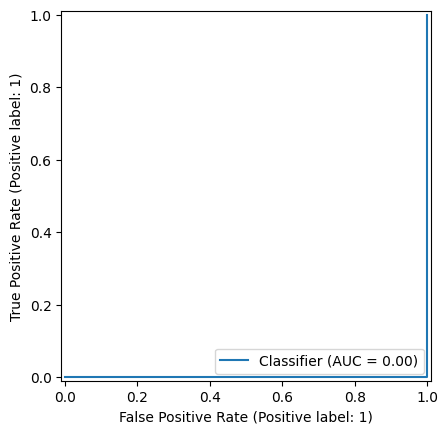

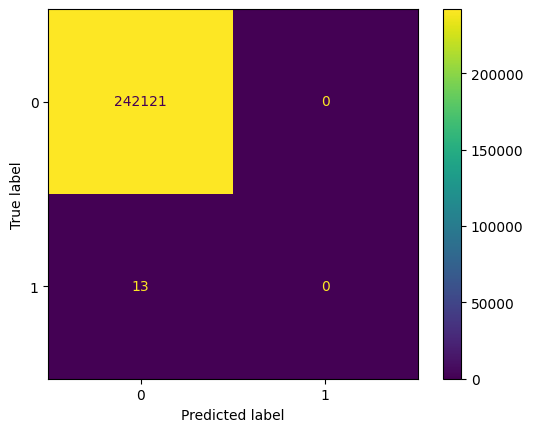

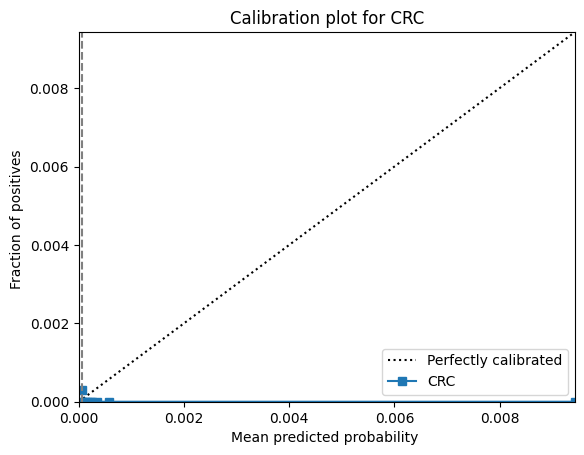

c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    242121
           1       0.00      0.00      0.00        13

    accuracy                           1.00    242134
   macro avg       0.50      0.50      0.50    242134
weighted avg       1.00      1.00      1.00    242134



c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\danie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(array([0, 0, 0, ..., 0, 0, 0]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.     

In [ ]:
evaluate(df_test = df_to_screen, test_var = "CRC", y_prob_pred=y_prob_pred, weights=[[1],[1]])

---
Option #2 Do colonoscopy to everyone

In [ ]:
net.clear_all_evidence()
net.set_evidence("Screening", "FIT")

y_prob_pred = []

for i in range(df.shape[0]):
    net.clear_evidence("Results_of_Screening")
    net.clear_evidence("Results_of_Colonoscopy")
    net.clear_evidence("Colonoscopy")
    
   
    sample = df.iloc[i].drop(labels = ["CRC"])

    sample_dict = sample.to_dict() 

    for keys, values in sample_dict.items():
        net.set_evidence(keys,values)

    net.update_beliefs()
    
    # Get probabilities of predicting or not CRC, choose one randomly using these probs
    scr_result_probs = net.get_node_value("Results_of_Screening")

    # Note that there is randomness in the method
    random_number = np.random.rand()

    # Step 2: Determine the category based on cumulative probabilities
    cumulative_probabilities = np.cumsum(scr_result_probs)
    category = np.argmax(cumulative_probabilities > random_number)

    net.set_evidence("Results_of_Screening", category)

    # Do a colonoscopy to everyone.
        
    net.set_evidence("Colonoscopy", "Colonoscopy")

    net.update_beliefs()
    
    col_result_probs = net.get_node_value("Results_of_Colonoscopy")
    random_number = np.random.rand()

    # Step 2: Determine the category based on cumulative probabilities
    cumulative_probabilities = np.cumsum(col_result_probs)
    category = np.argmax(cumulative_probabilities > random_number)

    net.set_evidence("Results_of_Colonoscopy", category)

    net.update_beliefs()

    crc_probs = net.get_node_value("CRC")

    y_prob_pred.append(crc_probs[1])

In [ ]:
evaluate(df_test = df, test_var = "CRC", y_prob_pred=y_prob_pred, weights=[[1],[1]])

Alternativa: Aumentar la sensibilidad de la clasificación del CRC mediante la red bayesiana a expensas de la especificidad. Después, realizar un test FIT a todos aquellos detectados positivos por la red. Después, hacer colonosocopia a todos los detectados positivos por el FIT. 

Estaríamos utilizando el valor predictivo de la red como paso previo al FIT (de hecho es el argumento principal del uso de los algoritmos predictivos para el diagnóstico). La idea es buena pero quizás nos encontramos con la limitación de que el FIT y la colonoscopia vienen modelizadas en el mismo contexto (la red bayesiana) que el resto de variables y por lo tanto no sea tan evidente su diferencial capacidad diagnóstica.

#### Binary cross entropy

---
## Elicitation

In [26]:
import pysmile
import pysmile_license
import numpy as np

In [27]:
net2 = pysmile.Network()
net2.read_file("genie_models/Basic_ID_screening_30042024.xdsl")

In [28]:
net2.update_beliefs()
probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
len(probs_crc_percondition)

384

In [29]:
net2.set_evidence("Screening", "gFOBT")

In [30]:
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
len(value_of_detection)

384

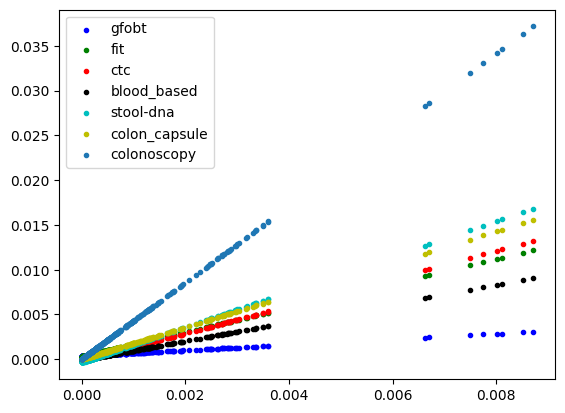

In [64]:
import matplotlib.pyplot as plt

net2.update_beliefs()

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "gFOBT")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
plt.scatter(probs_crc_percondition, value_of_detection, c = 'b',  marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "FIT")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
plt.scatter(probs_crc_percondition, value_of_detection, c = 'g', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "CTC")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
plt.scatter(probs_crc_percondition, value_of_detection, c = 'r', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "Blood_based")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
plt.scatter(probs_crc_percondition, value_of_detection, c = 'k', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.clear_all_evidence()
net2.set_evidence("Screening", "Stool_DNA")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
plt.scatter(probs_crc_percondition, value_of_detection, c = 'c', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.clear_all_evidence()
net2.set_evidence("Screening", "Colon_capsule")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
plt.scatter(probs_crc_percondition, value_of_detection, c = 'y', marker='.')


probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.clear_all_evidence()
net2.set_evidence("Colonoscopy", "Colonoscopy")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_detection_through_colonoscopy")
plt.scatter(probs_crc_percondition, value_of_detection, marker='.')


plt.legend(['gfobt', 'fit', 'ctc', 'blood_based', 'stool-dna', 'colon_capsule', 'colonoscopy'])

In [65]:
from numpy import ones,vstack
from numpy.linalg import lstsq
x_coords = probs_crc_percondition
y_coords = value_of_detection
A = vstack([x_coords,ones(len(x_coords))]).T
m, c = lstsq(A, y_coords, rcond = None)[0]
print("Line Solution is y = {m}x + {c}".format(m=m,c=c))

Line Solution is y = 4.267847389480004x + 2.3007079999904005e-05


(0.0, 0.002)

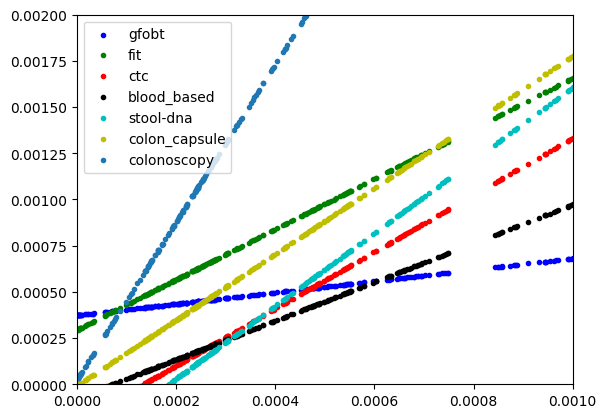

In [66]:
fig, ax = plt.subplots()

net2.update_beliefs()

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "gFOBT")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'b',  marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "FIT")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'g', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "CTC")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'r', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "Blood_based")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'k', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.clear_all_evidence()
net2.set_evidence("Screening", "Stool_DNA")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'c', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.clear_all_evidence()
net2.set_evidence("Screening", "Colon_capsule")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'y', marker='.')


probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.clear_all_evidence()
net2.set_evidence("Colonoscopy", "Colonoscopy")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_detection_through_colonoscopy")
ax.scatter(probs_crc_percondition, value_of_detection, marker='.')


ax.legend(['gfobt', 'fit', 'ctc', 'blood_based', 'stool-dna', 'colon_capsule', 'colonoscopy'])


ax.set_xlim(0, 0.001)
ax.set_ylim(0,0.002)

In [68]:
np.log(value_of_detection[-1] - value_of_detection[0])

-4.53849695742431

In [69]:
value_of_detection[0] * np.exp(np.array(value_of_detection) * (np.log(value_of_detection[-1] - value_of_detection[0])))

array([0.00091032, 0.00091097, 0.0009106 , 0.00091055, 0.0009111 ,
       0.00091109, 0.00091121, 0.00091147, 0.00091208, 0.00091274,
       0.00091226, 0.00091175, 0.00091394, 0.00091397, 0.00091396,
       0.00091389, 0.0009087 , 0.0009092 , 0.00090932, 0.00090863,
       0.00091383, 0.00091391, 0.00091387, 0.00091371, 0.0009104 ,
       0.00091095, 0.00091056, 0.00090989, 0.00091108, 0.00091109,
       0.0009112 , 0.00091145, 0.00091196, 0.00091263, 0.00091246,
       0.00091184, 0.00091396, 0.00091397, 0.00091396, 0.00091389,
       0.00090874, 0.00090952, 0.00090922, 0.0009083 , 0.00091384,
       0.00091392, 0.00091387, 0.00091369, 0.00090965, 0.00090949,
       0.00091025, 0.00091062, 0.00090979, 0.00090974, 0.00090971,
       0.00090975, 0.0009134 , 0.00091359, 0.00091343, 0.00091299,
       0.00091007, 0.00091023, 0.00091044, 0.00091055, 0.00091259,
       0.00091297, 0.00091274, 0.00091204, 0.00090561, 0.00090565,
       0.00090562, 0.00090586, 0.00090944, 0.00090967, 0.00091

In [113]:
net2.clear_all_evidence()

net2.set_evidence("Age", "age_4_adult")
net2.set_evidence("Sex", "M")
# net2.set_evidence("SES", "ses_1")
net2.set_evidence("SD", "SD_1_short")
net2.set_evidence("PA", "PA_2")
net2.set_evidence("Smoking", "sm_1_not_smoker")
# net2.set_evidence("Depression", False)
# net2.set_evidence("Anxiety", False)
net2.set_evidence("BMI", "bmi_3_overweight")
net2.set_evidence("Alcohol", "low")

Text(0.5, 1.0, 'Information provided by each screening method wrt to p(CRC)')

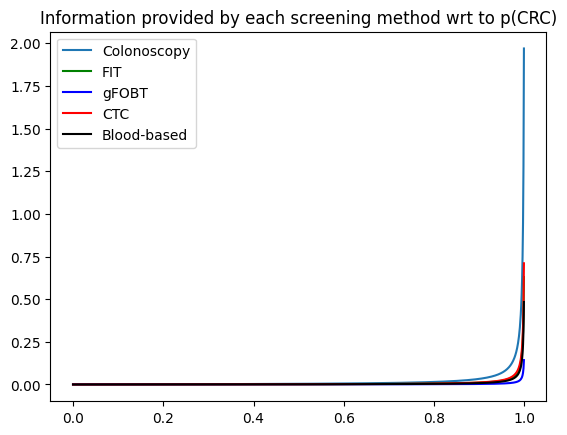

In [114]:
net2.set_evidence("Screening","FIT")
value_of_detection_fit = []
for i in np.arange(0,1,step=0.001):
    net2.set_virtual_evidence("CRC", [1-i, i])
    net2.update_beliefs()
    value_of_detection_fit.append(net2.get_node_value("Value_of_CRC_screening_detection"))


net2.set_evidence("Screening","gFOBT")
value_of_detection_gfobt = []
for i in np.arange(0,1,step=0.001):
    net2.set_virtual_evidence("CRC", [1-i, i])
    net2.update_beliefs()
    value_of_detection_gfobt.append(net2.get_node_value("Value_of_CRC_screening_detection"))


net2.set_evidence("Screening","CTC")
value_of_detection_ctc = []
for i in np.arange(0,1,step=0.001):
    net2.set_virtual_evidence("CRC", [1-i, i])
    net2.update_beliefs()
    value_of_detection_ctc.append(net2.get_node_value("Value_of_CRC_screening_detection"))


net2.set_evidence("Screening","Blood_based")
value_of_detection_bb = []
for i in np.arange(0,1,step=0.001):
    net2.set_virtual_evidence("CRC", [1-i, i])
    net2.update_beliefs()
    value_of_detection_bb.append(net2.get_node_value("Value_of_CRC_screening_detection"))


net2.set_evidence("Screening","Stool_DNA")
value_of_detection_sdna = []
for i in np.arange(0,1,step=0.001):
    net2.set_virtual_evidence("CRC", [1-i, i])
    net2.update_beliefs()
    value_of_detection_sdna.append(net2.get_node_value("Value_of_CRC_screening_detection"))


net2.set_evidence("Colonoscopy","Colonoscopy")
value_of_detection = []
for i in np.arange(0,1,step=0.001):
    net2.set_virtual_evidence("CRC", [1-i, i])
    net2.update_beliefs()
    value_of_detection.append(net2.get_node_value("Value_of_CRC_detection_through_colonoscopy"))

plt.plot(np.arange(0,1,step=0.001), value_of_detection[:1000])
plt.plot(np.arange(0,1,step=0.001), value_of_detection_fit[:1000], c = 'g')
plt.plot(np.arange(0,1,step=0.001), value_of_detection_gfobt[:1000], c = 'b')
plt.plot(np.arange(0,1,step=0.001), value_of_detection_ctc[:1000], c = 'r')
plt.plot(np.arange(0,1,step=0.001), value_of_detection_bb[:1000], c = 'k')

plt.legend(['Colonoscopy', 'FIT', 'gFOBT', 'CTC','Blood-based'])

plt.title("Information provided by each screening method wrt to p(CRC)")

Text(0.5, 1.0, 'Expected information provided by each screening method wrt to p(CRC)')

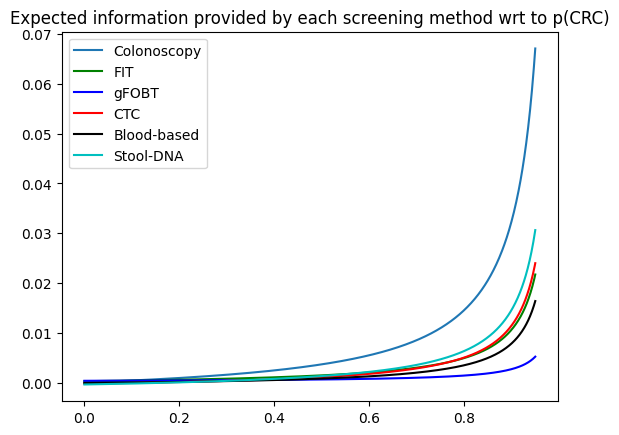

In [115]:
plt.plot(np.arange(0,0.95,step=0.001), value_of_detection[:950])
plt.plot(np.arange(0,0.95,step=0.001), value_of_detection_fit[:950], c = 'g')
plt.plot(np.arange(0,.95,step=0.001), value_of_detection_gfobt[:950], c = 'b')
plt.plot(np.arange(0,.95,step=0.001), value_of_detection_ctc[:950], c = 'r')
plt.plot(np.arange(0,.95,step=0.001), value_of_detection_bb[:950], c = 'k')
plt.plot(np.arange(0,.95,step=0.001), value_of_detection_sdna[:950], c = 'c')

plt.legend(['Colonoscopy', 'FIT', 'gFOBT', 'CTC','Blood-based', 'Stool-DNA'])

plt.title("Expected information provided by each screening method wrt to p(CRC)")

Text(0.5, 1.0, 'Expected information provided by each screening method wrt to p(CRC)')

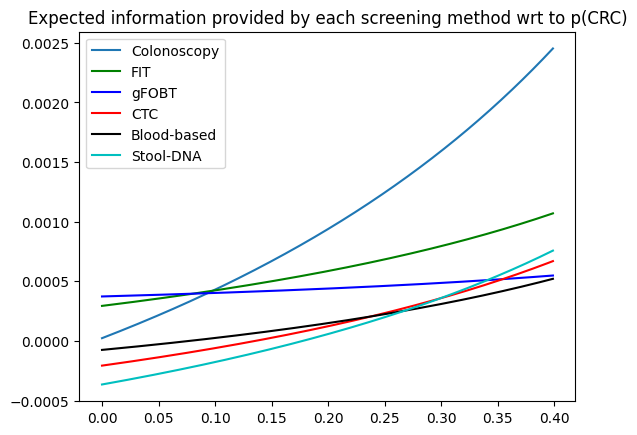

In [116]:
plt.plot(np.arange(0,0.4,step=0.001), value_of_detection[:400])
plt.plot(np.arange(0,0.4,step=0.001), value_of_detection_fit[:400], c = 'g')
plt.plot(np.arange(0,.4,step=0.001), value_of_detection_gfobt[:400], c = 'b')
plt.plot(np.arange(0,.4,step=0.001), value_of_detection_ctc[:400], c = 'r')
plt.plot(np.arange(0,.4,step=0.001), value_of_detection_bb[:400], c = 'k')
plt.plot(np.arange(0,.4,step=0.001), value_of_detection_sdna[:400], c = 'c')

plt.legend(['Colonoscopy', 'FIT', 'gFOBT', 'CTC','Blood-based', 'Stool-DNA'])

plt.title("Expected information provided by each screening method wrt to p(CRC)")

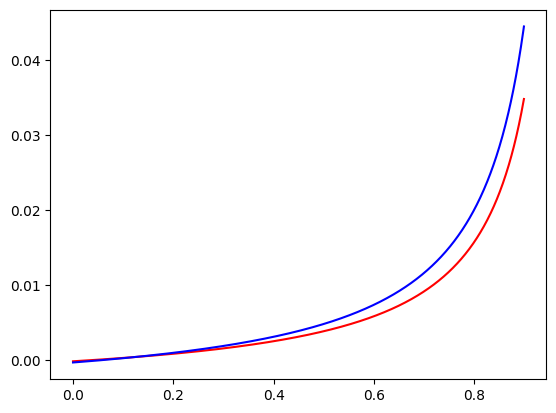

In [70]:
plt.plot(np.arange(0,.9,step=0.001), value_of_detection_ctc[:900], c = 'r')
plt.plot(np.arange(0,.9,step=0.001), value_of_detection_sdna[:900], c = 'b')

### Elicitation option 2

In [31]:
net2 = pysmile.Network()
net2.read_file("genie_models/Basic_ID_screening_30042024_2.xdsl")

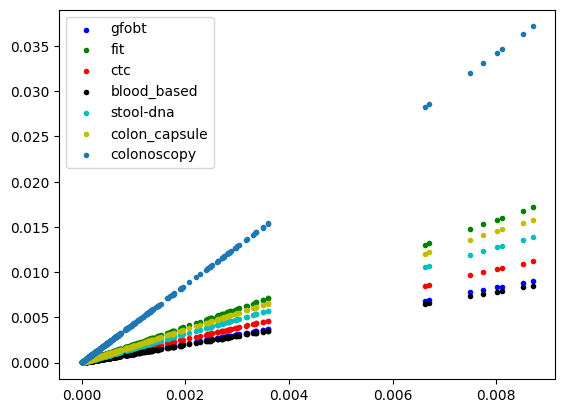

In [35]:
import matplotlib.pyplot as plt
net2.update_beliefs()

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "gFOBT")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
plt.scatter(probs_crc_percondition, value_of_detection, c = 'b',  marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "FIT")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
plt.scatter(probs_crc_percondition, value_of_detection, c = 'g', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "CTC")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
plt.scatter(probs_crc_percondition, value_of_detection, c = 'r', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "Blood_based")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
plt.scatter(probs_crc_percondition, value_of_detection, c = 'k', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.clear_all_evidence()
net2.set_evidence("Screening", "Stool_DNA")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
plt.scatter(probs_crc_percondition, value_of_detection, c = 'c', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.clear_all_evidence()
net2.set_evidence("Screening", "Colon_capsule")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
plt.scatter(probs_crc_percondition, value_of_detection, c = 'y', marker='.')


probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.clear_all_evidence()
net2.set_evidence("Colonoscopy", "Colonoscopy")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_detection_through_colonoscopy")
plt.scatter(probs_crc_percondition, value_of_detection, marker='.')


plt.legend(['gfobt', 'fit', 'ctc', 'blood_based', 'stool-dna', 'colon_capsule', 'colonoscopy'])

(0.0, 0.002)

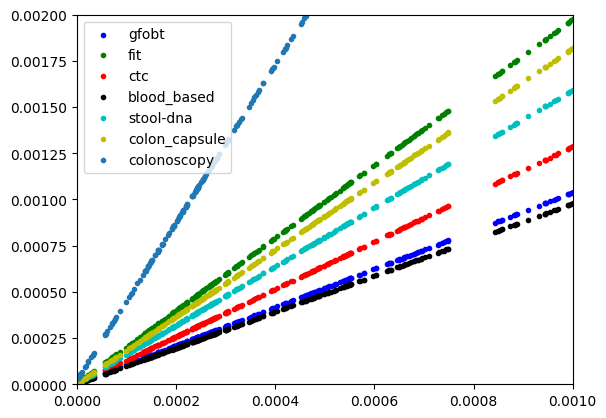

In [36]:
fig, ax = plt.subplots()

net2.update_beliefs()

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "gFOBT")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'b',  marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "FIT")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'g', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "CTC")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'r', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "Blood_based")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'k', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.clear_all_evidence()
net2.set_evidence("Screening", "Stool_DNA")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'c', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.clear_all_evidence()
net2.set_evidence("Screening", "Colon_capsule")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'y', marker='.')


probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.clear_all_evidence()
net2.set_evidence("Colonoscopy", "Colonoscopy")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_detection_through_colonoscopy")
ax.scatter(probs_crc_percondition, value_of_detection, marker='.')


ax.legend(['gfobt', 'fit', 'ctc', 'blood_based', 'stool-dna', 'colon_capsule', 'colonoscopy'])


ax.set_xlim(0, 0.001)
ax.set_ylim(0,0.002)

(0.0, 2e-05)

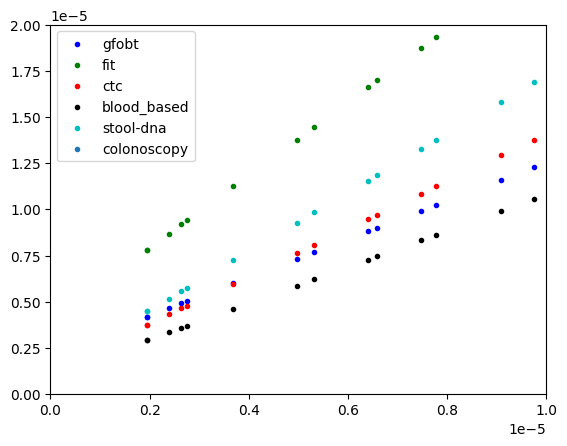

In [80]:
fig, ax = plt.subplots()

net2.update_beliefs()

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "gFOBT")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'b',  marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "FIT")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'g', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "CTC")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'r', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.set_evidence("Screening", "Blood_based")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'k', marker='.')

probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.clear_all_evidence()
net2.set_evidence("Screening", "Stool_DNA")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_screening_detection")
ax.scatter(probs_crc_percondition, value_of_detection, c = 'c', marker='.')


probs_crc_percondition = np.array(net2.get_node_value("CRC")).reshape(-1,2).transpose()[1]
net2.clear_all_evidence()
net2.set_evidence("Colonoscopy", "Colonoscopy")
net2.update_beliefs()
value_of_detection = net2.get_node_value("Value_of_CRC_detection_through_colonoscopy")
ax.scatter(probs_crc_percondition, value_of_detection, marker='.')


ax.legend(['gfobt', 'fit', 'ctc', 'blood_based', 'stool-dna', 'colonoscopy'])


ax.set_xlim(0, 0.00001)
ax.set_ylim(0,0.00002)

$\underline{2nd idea - Virtual Evidence}$

Make use of the tools offered by the influence diagram and set virtual evidences with increasing probabilities for CRC, by which we will obtain the expected information value provided by each of the screening methods. (Intuition may not be clear)

This method requires setting evidence for the node C (all the covariates). In the following example, we suppose that we have a male adult patient with short sleep, high PA, not a smoker, with overweight and low alcohol consumption.

If we define the value function using the point-wise conditional mutual information (pcmi) we obtain the plots shown in Figure 

Text(0.5, 1.0, 'Information provided by each screening method wrt to p(CRC)')

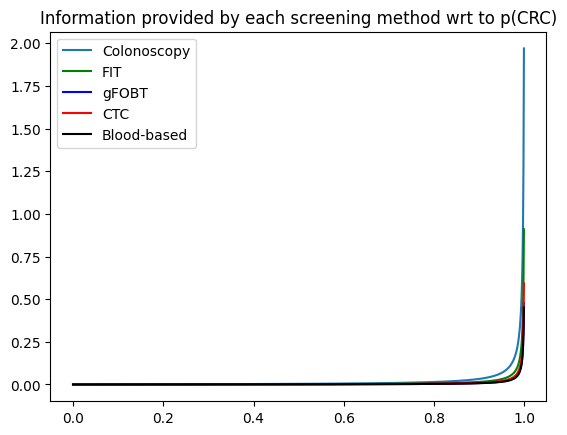

In [74]:
net2.clear_all_evidence()

net2.set_evidence("Age", "age_4_adult")
net2.set_evidence("Sex", "M")
# net2.set_evidence("SES", "ses_1")
net2.set_evidence("SD", "SD_1_short")
net2.set_evidence("PA", "PA_2")
net2.set_evidence("Smoking", "sm_1_not_smoker")
# net2.set_evidence("Depression", False)
# net2.set_evidence("Anxiety", False)
net2.set_evidence("BMI", "bmi_3_overweight")
net2.set_evidence("Alcohol", "low")


net2.set_evidence("Screening","FIT")
value_of_detection_fit = []
for i in np.arange(0,1,step=0.001):
    net2.set_virtual_evidence("CRC", [1-i, i])
    net2.update_beliefs()
    value_of_detection_fit.append(net2.get_node_value("Value_of_CRC_screening_detection"))


net2.set_evidence("Screening","gFOBT")
value_of_detection_gfobt = []
for i in np.arange(0,1,step=0.001):
    net2.set_virtual_evidence("CRC", [1-i, i])
    net2.update_beliefs()
    value_of_detection_gfobt.append(net2.get_node_value("Value_of_CRC_screening_detection"))


net2.set_evidence("Screening","CTC")
value_of_detection_ctc = []
for i in np.arange(0,1,step=0.001):
    net2.set_virtual_evidence("CRC", [1-i, i])
    net2.update_beliefs()
    value_of_detection_ctc.append(net2.get_node_value("Value_of_CRC_screening_detection"))


net2.set_evidence("Screening","Blood_based")
value_of_detection_bb = []
for i in np.arange(0,1,step=0.001):
    net2.set_virtual_evidence("CRC", [1-i, i])
    net2.update_beliefs()
    value_of_detection_bb.append(net2.get_node_value("Value_of_CRC_screening_detection"))


net2.set_evidence("Screening","Stool_DNA")
value_of_detection_sdna = []
for i in np.arange(0,1,step=0.001):
    net2.set_virtual_evidence("CRC", [1-i, i])
    net2.update_beliefs()
    value_of_detection_sdna.append(net2.get_node_value("Value_of_CRC_screening_detection"))


net2.set_evidence("Colonoscopy","Colonoscopy")
value_of_detection = []
for i in np.arange(0,1,step=0.001):
    net2.set_virtual_evidence("CRC", [1-i, i])
    net2.update_beliefs()
    value_of_detection.append(net2.get_node_value("Value_of_CRC_detection_through_colonoscopy"))

plt.plot(np.arange(0,1,step=0.001), value_of_detection[:1000])
plt.plot(np.arange(0,1,step=0.001), value_of_detection_fit[:1000], c = 'g')
plt.plot(np.arange(0,1,step=0.001), value_of_detection_gfobt[:1000], c = 'b')
plt.plot(np.arange(0,1,step=0.001), value_of_detection_ctc[:1000], c = 'r')
plt.plot(np.arange(0,1,step=0.001), value_of_detection_bb[:1000], c = 'k')

plt.legend(['Colonoscopy', 'FIT', 'gFOBT', 'CTC','Blood-based'])

plt.title("Information provided by each screening method wrt to p(CRC)")

Text(0.5, 1.0, 'Expected information provided by each screening method wrt to p(CRC)')

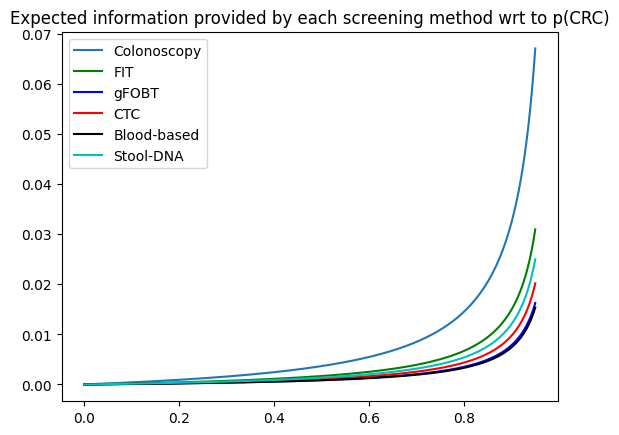

In [75]:
plt.plot(np.arange(0,0.95,step=0.001), value_of_detection[:950])
plt.plot(np.arange(0,0.95,step=0.001), value_of_detection_fit[:950], c = 'g')
plt.plot(np.arange(0,.95,step=0.001), value_of_detection_gfobt[:950], c = 'b')
plt.plot(np.arange(0,.95,step=0.001), value_of_detection_ctc[:950], c = 'r')
plt.plot(np.arange(0,.95,step=0.001), value_of_detection_bb[:950], c = 'k')
plt.plot(np.arange(0,.95,step=0.001), value_of_detection_sdna[:950], c = 'c')

plt.legend(['Colonoscopy', 'FIT', 'gFOBT', 'CTC','Blood-based', 'Stool-DNA'])

plt.title("Expected information provided by each screening method wrt to p(CRC)")

Text(0.5, 1.0, 'Expected information provided by each screening method wrt to p(CRC)')

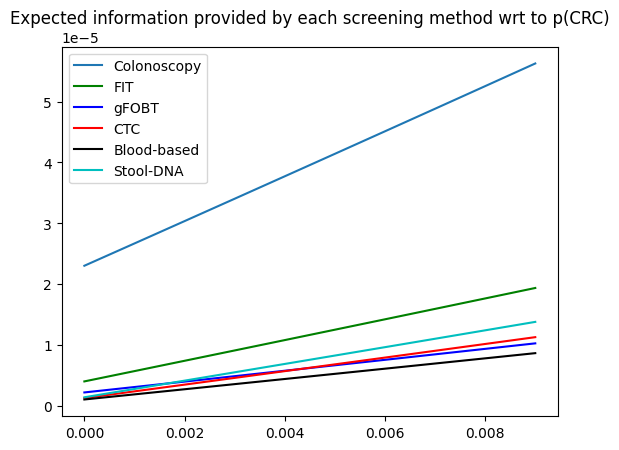

In [76]:
plt.plot(np.arange(0,0.01,step=0.001), value_of_detection[:10])
plt.plot(np.arange(0,0.01,step=0.001), value_of_detection_fit[:10], c = 'g')
plt.plot(np.arange(0,.01,step=0.001), value_of_detection_gfobt[:10], c = 'b')
plt.plot(np.arange(0,.01,step=0.001), value_of_detection_ctc[:10], c = 'r')
plt.plot(np.arange(0,.01,step=0.001), value_of_detection_bb[:10], c = 'k')
plt.plot(np.arange(0,.01,step=0.001), value_of_detection_sdna[:10], c = 'c')

plt.legend(['Colonoscopy', 'FIT', 'gFOBT', 'CTC','Blood-based', 'Stool-DNA'])


plt.title("Expected information provided by each screening method wrt to p(CRC)")

In [51]:
import graphviz

# Create a new graph
graph = graphviz.Digraph()

# Add nodes Z, X, Y, and V
graph.node('C')
graph.node('Z', shape = 'square')
graph.node('X')
graph.node('Y')
graph.node('V', shape='hexagon') 
# Add directed edges
graph.edge('C', 'Z')
graph.edge('C', 'Y')
graph.edge('Z', 'X')
graph.edge('Y', 'X')
graph.edge('X', 'V')
graph.edge('Y', 'V')

# Add dashed directed edge
graph.edge('Z', 'V', style='dashed')

# Render the graph
graph.render('graph', format='png', cleanup=True)

'graph.png'

In [47]:
graph.view()


'graph.pdf'

## Trash?

### With pyAgrum

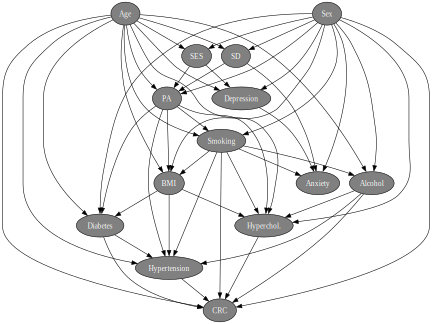

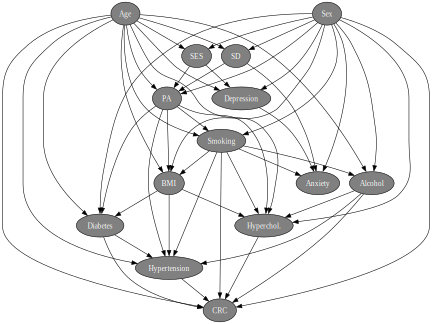

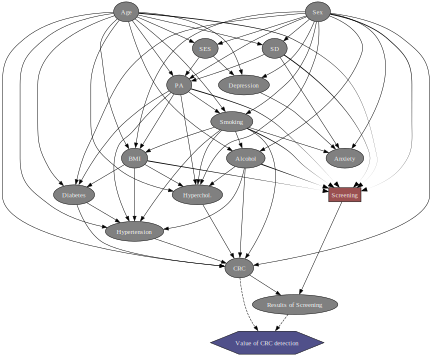

In [135]:
import pyAgrum as gum

model_ID = gum.InfluenceDiagram()
model_ID.loadBIFXML("CRC_BN.xml")

import pyAgrum.lib.notebook as gnb
gnb.showInfluenceDiagram(model_ID)

screening = model_ID.addDecisionNode(gum.LabelizedVariable("Screening", "Screening", 3))
value = model_ID.addUtilityNode(gum.LabelizedVariable("Value of CRC detection", "Value of CRC detection", 1))
scr_results = model_ID.addChanceNode(gum.LabelizedVariable("Results of Screening", "Results of Screening", 3))


model_ID.addArc(model_ID.idFromName("Alcohol"), screening)
model_ID.addArc(model_ID.idFromName("Sex"), screening)
model_ID.addArc(model_ID.idFromName("BMI"), screening)
model_ID.addArc(model_ID.idFromName("PA"), screening)
model_ID.addArc(model_ID.idFromName("Smoking"), screening)
model_ID.addArc(model_ID.idFromName("Age"), screening)
model_ID.addArc(model_ID.idFromName("SD"), screening)

model_ID.addArc(screening, scr_results)

model_ID.addArc(model_ID.idFromName("CRC"), scr_results)

model_ID.addArc(scr_results, value)
# model_ID.addArc(screening, value)
model_ID.addArc(model_ID.idFromName("CRC"), value)

gnb.showInfluenceDiagram(model_ID)

In [136]:
model_ID.cpt("Results of Screening")[{"Screening":0, "CRC":False}] = [1, 0, 0]
model_ID.cpt("Results of Screening")[{"Screening":1, "CRC":False}] = [0, 0.022, 0.978]
model_ID.cpt("Results of Screening")[{"Screening":2, "CRC":False}] = [0, 0.034, 0.966]

model_ID.cpt("Results of Screening")[{"Screening":0, "CRC":True}] = [1, 0, 0]
model_ID.cpt("Results of Screening")[{"Screening":1, "CRC":True}] = [0, 0.45, 0.55]
model_ID.cpt("Results of Screening")[{"Screening":2, "CRC":True}] = [0, 0.75, 0.25]


In [142]:
model_ID.cpt("Results of Screening")

(pyAgrum.Potential<double>@000002677868FB80) 
             ||  Results of Screening       |
Screen|CRC   ||0        |1        |2        |
------|------||---------|---------|---------|
0     |False || 1.0000  | 0.0000  | 0.0000  |
1     |False || 0.0000  | 0.0220  | 0.9780  |
2     |False || 0.0000  | 0.0340  | 0.9660  |
0     |True  || 1.0000  | 0.0000  | 0.0000  |
1     |True  || 0.0000  | 0.4500  | 0.5500  |
2     |True  || 0.0000  | 0.7500  | 0.2500  |

In [173]:
model_ID.utility(value)[{}] = [
    [
        [0], [1], [100000]
    ],
    [
        [0], [0], [30000]
    ]
]

In [174]:
model_ID.utility(value)

(pyAgrum.Potential<double>@000002677868FD20) 
             ||  Value o|
Result|CRC   ||0        |
------|------||---------|
0     |False || 0.0000  |
1     |False || 1.0000  |
2     |False || 100000.0000|
0     |True  || 0.0000  |
1     |True  || 0.0000  |
2     |True  || 30000.0000|

In [180]:
id_inference = gum.ShaferShenoyLIMIDInference(model_ID)
id_inference.makeInference()

In [176]:
id_inference.posterior("Screening")

(pyAgrum.Potential<double>@000002675861D670) 
  Screening                  |
0        |1        |2        |
---------|---------|---------|
 0.0000  | 1.0000  | 0.0000  |

In [177]:
id_inference.setEvidence({"CRC":True})
id_inference.makeInference()

In [185]:
from pyAgrum.lib.explain import showInformation

model_ID = gum.BayesNet()
model_ID.loadBIFXML("CRC_BN.xml")

showInformation(model_ID)

In [194]:
from pyAgrum.lib.explain import ShapValues

results = ShapValues(model_ID, "CRC")

### Cost efectiveness

In [ ]:
net.get_all_node_ids()

['Sex',
 'Age',
 'SD',
 'SES',
 'Depression',
 'PA',
 'Smoking',
 'Anxiety',
 'Alcohol',
 'BMI',
 'Hyperchol_',
 'Diabetes',
 'Hypertension',
 'CRC',
 'Screening',
 'Results_of_Screening',
 'Colonoscopy',
 'Results_of_Colonoscopy',
 'Value_of_CRC_detection',
 'Cost_of_Screening',
 'Patient_comfort',
 'Complications',
 'Cost_of_complications',
 'Utility']

In [ ]:
net.update_beliefs()

In [ ]:
net.get_mau_expressions("Utility")

['Cost_of_Screening+Cost_of_complications+100*Patient_comfort+3e+06*Value_of_CRC_detection']

In [ ]:
wtp = 10
expression = f'1*Cost_of_Screening+{wtp}*Value_of_CRC_detection+Cost_of_complications+Patient_comfort'

In [ ]:
net.set_mau_expressions(node_id = "Utility", expressions = [expression])

In [ ]:
net.get_node_value("Utility")

SMILEException: SMILE Error 1 in function Network.GetValue

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import math

class Inf_diag_inference:
    def __init__(self):
        print("Starting inference...")
        inf_diag = pysmile.Network()
        inf_diag.read_file("genie_models/Basic_ID_screening.xdsl")
        
        #print("No evidence set.")
        #inf_diag.update_beliefs()
        #self.print_cost_utility(inf_diag)

        node_id = ["Sex", "Age", "PA", "Smoking", "Alcohol", "BMI"]
        outcome_id = ["W", "age_5_old_adult", "PA_2", "sm_3_ex_smoker", "low", "bmi_4_obese"]
        self.change_evidence_and_update(inf_diag, node_id, outcome_id)

        tot_array = self.plot_wtp(inf_diag)

        for tool in range(tot_array.shape[1]):
            plt.plot(tot_array[:,tool])

        '''print("Setting Forecast=Good.")
        self.change_evidence_and_update(net, "Forecast", "Good")
        print("Adding Economy=Up")
        self.change_evidence_and_update(net, "Economy", "Up")'''

        print("Inference complete.")

    def change_evidence_and_update(self, net, node_id, outcome_id):
        for i in range(len(node_id)):
            if outcome_id[i] is not None:
                net.set_evidence(node_id[i], outcome_id[i])
            else:
                net.clear_evidence(node_id[i])

        net.update_beliefs()
        self.print_cost_utility(net)

    def print_cost_utility(self, net):
        expected_utility = net.get_node_value("Cost_utility")
        util_parents = net.get_value_indexing_parents("Cost_utility")
        self.print_utility_matrix(net, expected_utility, util_parents)

    def print_utility_matrix(self, net, mtx, parents):
        dim_count = 1 + len(parents)
        dim_sizes = [0] * dim_count
        for i in range(0, dim_count - 1):
            dim_sizes[i] = net.get_outcome_count(parents[i])
        dim_sizes[len(dim_sizes) - 1] = 1
        coords = [0] * dim_count
        for elem_idx in range(0, len(mtx)):
            self.index_to_coords(elem_idx, dim_sizes, coords)
            str_to_print = " Utility("
            if dim_count > 1:
                for parent_idx in range(0, len(parents)):
                    if parent_idx > 0:
                        str_to_print += ","
                    parent_handle = parents[parent_idx]
                    str_to_print += net.get_node_id(parent_handle) + \
                    "=" + net.get_outcome_id(parent_handle,
                                                coords[parent_idx])
            str_to_print += ")=" + str(mtx[elem_idx])
            print(str_to_print)
        print("")

    def index_to_coords(self, index, dim_sizes, coords):
        prod = 1
        for i in range(len(dim_sizes) - 1, -1, -1):
            coords[i] = int(index / prod) % dim_sizes[i]
            prod *= dim_sizes[i]

    def plot_wtp(self, net ):
        total_array = []
        for wtp in range(0, 20, 1):
            print(np.log(wtp))
            expression = f'1*Cost_of_Screening+{wtp}*Utility_of_Screening+Cost_of_Perforation+Cost_of_Bleeding+Cost_of_other_complications'
            net.set_mau_expressions(node_id = "Cost_utility", expressions = [expression])
            net.update_beliefs()
            total_array.append(net.get_node_value("Cost_utility"))

        np_tot_array = np.array(total_array)
        np_tot_array.reshape(-1,7)
        print(np_tot_array)
        return np_tot_array


In [ ]:
Inf_diag_inference()

Starting inference...


SMILEException: SMILE Error Occured. Invalid node handle: -2